### MLP（多层感知机模型）

在bigram设计中，只考虑了前一个字符作为上下文（context），导致模型预测的效果不好。解决方法是要考虑更多的上下文来预测序列中的下一个字符。但是我们发现情况会变得很复杂，这张表格的大小会迅速增长，实际上它会随着上下文长度的增加呈指数级增长。

MLP用于预测序列（sequence）中的下一个字符

In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [42]:
# read in all the words
words = open("names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [178]:
len(words)

32033

In [44]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
#for w in words[:5]:
for w in words:
    
    #print(w)
    context = [0] * block_size # initialize context block 0->'.'
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

In [179]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    #for w in words[:5]:
    for w in words:

        #print(w)
        context = [0] * block_size # initialize context block 0->'.'
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
# traning split, dev/validation split, test split : 80%, 10%, 10%
n1 = int(0.8*len(words)) # 80% of the words
n2 = int(0.9*len(words)) # 90% of the words

# training-split
Xtr, Ytr = build_dataset(words[:n1])
# dev/validation split
Xdev, Ydev = build_dataset(words[n1:n2])
# test-split
Xte, Yte = build_dataset(words[n2:])

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


X是输入示例（context block），Y是标签（label），即紧接着上下文窗口的下一个字符

##### 构建特征矩阵C，即词嵌入查找表（embedding lookup table C）

table C有27个可能的字符，我们将其嵌入到一个较低维度的空间中（这里是二维）

In [ ]:
C = torch.randn((27, 2))

In [ ]:
emb = C[X]
emb.shape

这里的`C[X]`用到了**张量的索引操作**：使用张量`X`作为索引去访问张量`C`，其行为取决于索引张量`X`的形状和数据类型。`C[X]`中，`X`充当**行索引**（32x3=96个范围在`[0,26]`的整数索引值，故可用于`C`的行索引），保留`C`的列维度，最终可得出`C[X]`形状为`[32, 3, 2]`

In [ ]:
# 隐藏层：该层的输入数量为3x2，因为有三个block，每个block有两个维度的嵌入

W1 = torch.randn((6, 100)) # hyperparameter是自定义的
b1 = torch.randn(100)

为了避免硬编码数值32，这里使用`emb.shape[0]`或者直接`-1`让pytorch自己推理出32。以下都是等价的写法：

```python
h = torch.tanh(emb.view(32, 6) @ W1 + b1)
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
```

======================================

In [ ]:
emb @ W1 + b1

In [ ]:
# 举例，将3个词嵌入通过“连接”压缩成了32x6的形状
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape 

In [ ]:
# 将emb张量移除1维度，得到一组序列后通过“连接”压缩成了32x6
torch.cat(torch.unbind(emb, 1), 1).shape

In [ ]:
emb.shape

In [ ]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

======================================

为了避免硬编码数值32，这里使用`emb.shape[0]`或者直接`-1`让pytorch自己推理出32。以下都是等价的写法：

```python
h = torch.tanh(emb.view(32, 6) @ W1 + b1)
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
```
另外还需注意这里的`+ b1`用到了**广播机制**，因为矩阵`emb.view(-1, 6) @ W1`的形状是`[32, 100]`，`b1`的形状是`[100]`，两者不能直接相乘。在广播下，`b1`的形状拓展为`[1, 100]`，此时相乘，每个`b1`的偏置向量都会被加到这个矩阵的所有行上

In [ ]:
# hidden layer of activations

h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [ ]:
h

In [ ]:
h.shape

In [ ]:
# output layer: 

W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdim=True)

In [ ]:
prob.shape

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

In [ ]:
# --------------------- now made repectable :) ----------------------

In [184]:
Xtr.shape, Ytr.shape # trainig dataset

(torch.Size([182424, 3]), torch.Size([182424]))

In [282]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
# hidden layer 's weights and bias
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
# output layer 's weights and bias
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [283]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [284]:
for p in parameters:
    p.requires_grad = True

In [285]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # actual Learning Rates we wanna search for

In [286]:
lri = []
lossi = []
stepi = []

In [295]:
for i in range(50000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

#print(loss.item()) # Attention! this output is only the loss for that mini batch!

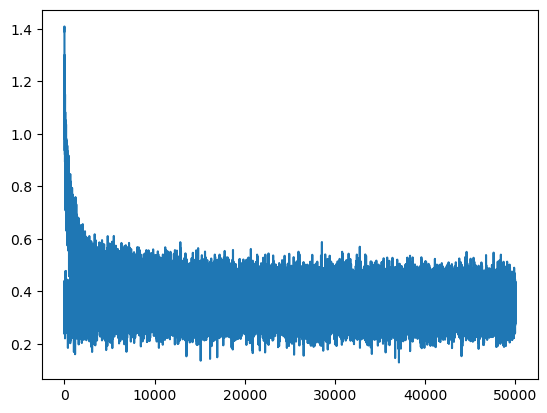

In [292]:
plt.plot(stepi, lossi)

In [296]:
# 评估训练集的损失
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1774, grad_fn=<NllLossBackward0>)

In [297]:
# 评估开发集的损失：
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2219, grad_fn=<NllLossBackward0>)

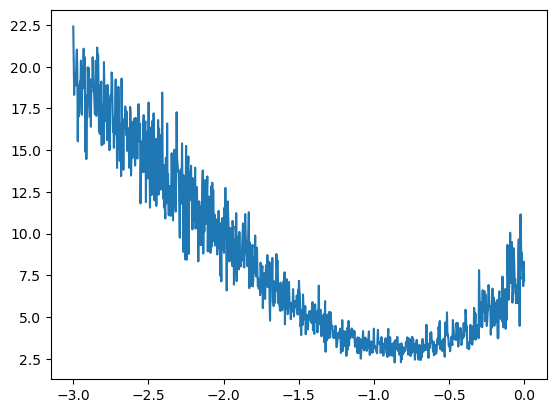

In [68]:
plt.plot(lri, lossi)

In [ ]:
# traning split, dev/validation split, test split
# 80%, 10%, 10%

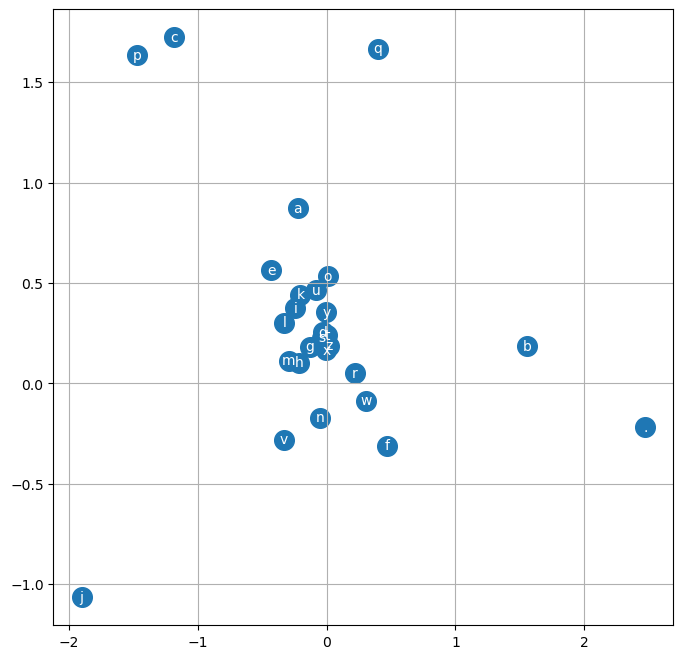

In [298]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')